In [52]:
import matplotlib.pyplot as plt 
import numpy as np
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal

The Time Dependent Schrodinger Equation (in a position basis with infinite boundaries) is 

$$ i \hbar \frac{\partial}{\partial t} \psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x) \psi(x,t) \hspace{20mm} \psi(0, t) = \psi(L,t)=0 $$

We don't need to deal with extra parameters like $m$, $\hbar$, etc. Multiplying both sides by $mL^2$ where $L$ is the characteristic length of the problem (here we are bounded in length $L$)

$$ i mL^2 \hbar \frac{\partial}{\partial t} \psi = -\frac{1}{2}\hbar^2 L^2\frac{\partial^2}{\partial x^2}\psi + mL^2V(x) \psi $$

Now choose the convention $\hbar=1$ (So Joules=1/Seconds) and make the transformation

* $x'=\frac{x}{L}$
* $t' = \frac{t}{mL^2}$
* $V' = mL^2V$

You can check that with the convention $\hbar=1$, all of the three quantities above are dimensionless. The Schrodinger equation with respect to these three variables becomes

$$ i \frac{\partial}{\partial t'} \psi = -\frac{1}{2}\frac{\partial^2}{\partial x'^2}\psi + V'(x) \psi $$

We solve this equation for $x'$ and $t'$ and then solve for $x$ and $t$ using 

* $x = Lx'$
* $t = (mL^2) t'$
* $V = (mL^2)^{-1} V'$

**For all the numerical work we will drop the primes on $x'$, $t'$, and $V'$ but know that we are working with the primed quantities**

# Technique 1: Finite Difference

Choose a discrete grid with spacing $\Delta x$ and $\Delta t$ and let $\psi_j^{m} = \psi(j\Delta x, m\Delta t)$

$$i\frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta t} = - \frac{1}{2}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta x^2} +V(x)\psi_j^m$$ 



# Technique 2: Eigenstate Evolution

Find the $\psi_j$ and $E_j$'s that satisfy

$$ -\frac{1}{2}\frac{\partial^2}{\partial x^2}\psi + V(x) \psi = E\psi$$

And then

$$\psi(x,t) = \sum_{j=0}^\infty c_j \psi_j(x) e^{-i E_j t} \hspace{20mm} c_j = \int_{-\infty}^{\infty} \psi(x, 0)\psi_j^*(x) dx$$

## A. Using finite difference 

In [53]:
# use finite difference 

Nx = 301
Nt = 100000
x = np.linspace(0,1,Nx)
dx = 1/(Nx -1)
dt = 1e-7

# wave fucntion at t =0 
psi0 = np.sqrt(2)* np.sin(np.pi*x)

# potential 
mu,sigma = 0.5, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))

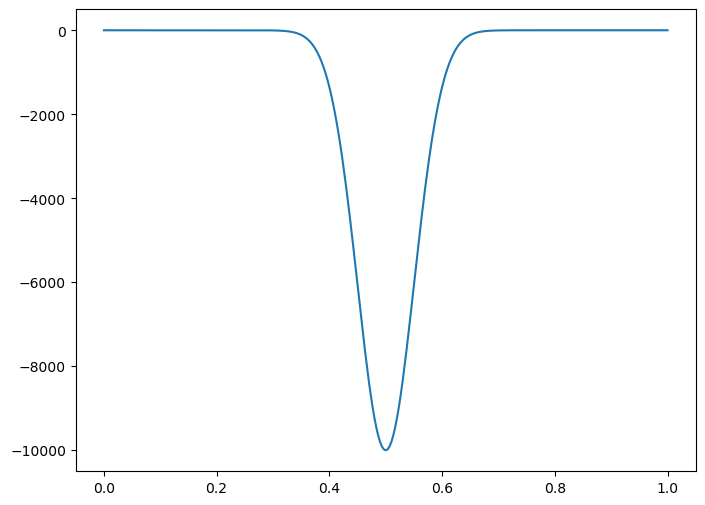

In [54]:
plt.plot(x,V)

In [55]:
print(f' for finite difference to work dt/dx^2 = {dt/dx**2} should be smaller')

 for finite difference to work dt/dx^2 = 0.008999999999999998 should be smaller


In [56]:
psi = np.zeros([Nt,Nx])
psi[0] = psi0

In [57]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx # normalization constant 
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal         # normalize the wave fn 
        
    return psi

In [58]:
psi_m1 = compute_psi(psi.astype(complex))

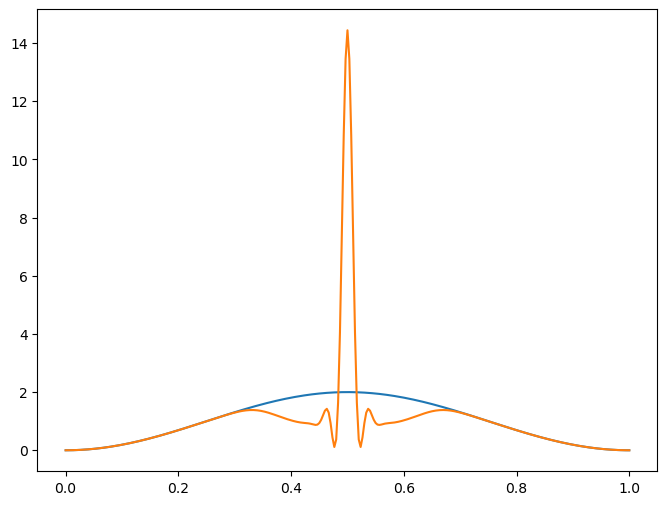

In [60]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(x,np.absolute(psi_m1[0]**2))
plt.plot(x,np.absolute(psi_m1[10000]**2))


## B. Using eign state evolution

In [61]:
# the second method, using the eign state evolution 
Nx = 301 
x = np.linspace(0,1,Nx)
dx = 1/(Nx-1)
psi0 = np.sqrt(2)*np.sin(np.pi*x)                       # initial WF 


def V(x):                                               # potential 
    mu, sigma = 1/2, 1/20
    return -1e4*np.exp(-(x-1/2)**2/(2*(1/20)**2))
    

In [62]:
# we used this in 1d schrodinger problem
d = 1/dx**2 + V(x)[1:-1]
e = -1/(2*dx**2)*np.ones(len(d)-1)
w,v = eigh_tridiagonal(d,e)

In [63]:
# get the fist 50 eign values and states (for eign states we need to pad zero at the start and end)
# np.pad ->  (arr,[(before_1,after_1),(before_2,after_2)])
E_js = w[:50]
psi_js = np.pad(v.T[:50],[(0,0),(1,1)],mode='constant') # psi_j with zero padding 
cs = np.dot(psi_js,psi0)


def psi_m2(t):
    return psi_js.T @ (cs*np.exp(-1j*E_js*t))

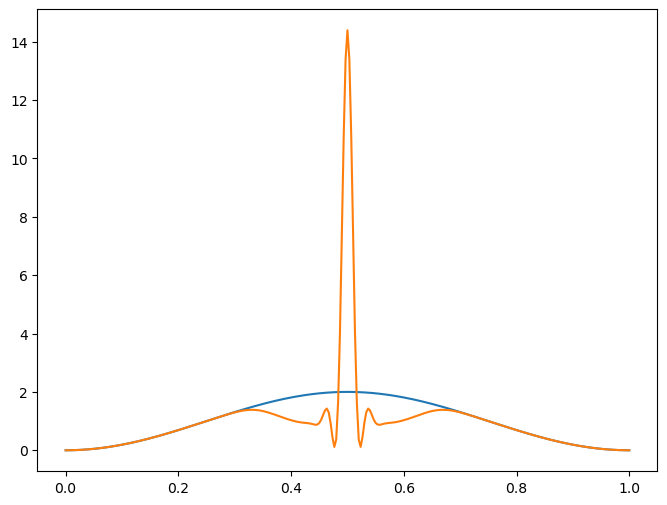

In [64]:
import matplotlib.pyplot as plt
plt.plot(x, psi0**2)
plt.plot(x, np.absolute(psi_m2(10000*dt))**2)
plt.rcParams["figure.figsize"] = (8,6)